In [1]:
from glob import glob 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imageio
import skimage
import numpy as np
from PIL import Image, ImageEnhance

input_dataset_path = './Data/Original/'
output_dataset_path = './Data/Output/'

In [2]:
mtx = np.array([[5.18460289e+03, 0.00000000e+00, 8.93439037e+02],
 [0.00000000e+00, 4.99241883e+03, 1.87367393e+02],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
dist = np.array([[-3.02398281e-01, -4.96879202e+00,  3.38606915e-02,  5.99562903e-03, 1.22428270e+01]])

mtx_gt = np.array([[2.501501083289876e+03, 0.00000000e+00, 5.201581619358745e+02],
 [0.00000000e+00, 2.502398082649436e+03, 5.725795845858204e+02],
 [0, 0, 1.00000000e+00]])

dist_gt = np.array([[-0.1456, -0.1237,  0,  0, 0]])

H = np.array([[ 1.59314223e+00,-3.39848873e-03,-7.47812129e+01],[6.00408489e-03, 1.57792749e+00,-2.22786297e+02],[1.41525738e-05,-7.16701000e-06,1.00000000e+00]])
H = np.array([[ 1.54505432e+00, -1.61177374e-02, -6.56840187e+01],[-9.77950514e-03,  1.54344146e+00, -2.04369001e+02],[-5.46429346e-06, -1.60810644e-05,  1.00000000e+00]])

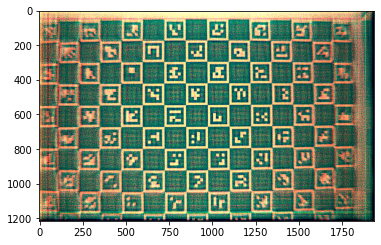

In [3]:
np_psf_path = 'Data/PSF/normalized_psf_601.npy'
psfs = np.load(np_psf_path) 
new_psf = np.zeros((psfs.shape[0],psfs.shape[1],psfs.shape[2])).astype(np.float32)
fake_psf = psfs[...,1]
fake_psf = fake_psf[0,...] + np.flipud(np.transpose(fake_psf)) + np.transpose(fake_psf)
fake_psf = fake_psf + np.fliplr(fake_psf)
fake_psf /= 6
for i in range(3):
    new_psf[...,i] = fake_psf
#new_psf[0,...] = psfs
img_meta = plt.imread('./Data/Original/metalens.png')


def simple_wiener_deconv(psf,blur_image_np,SNR,size):
    deconvolved_img = np.zeros_like(blur_image_np[...])
    for i in range(3):
        deconvolved_img[...,i] = skimage.restoration.wiener(blur_image_np[:,:,i], psfs[...,i], SNR)
    return deconvolved_img
#blur_image = plt.imread('/baselines/u-net-group/Data/meta.png')

a = simple_wiener_deconv(new_psf,img_meta,0.00015,300)
a = np.uint8(a.clip(0,1)*255)
plt.imshow(a)



TypeError: 'NoneType' object is not subscriptable

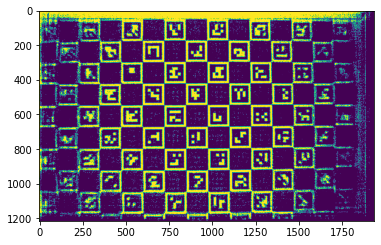

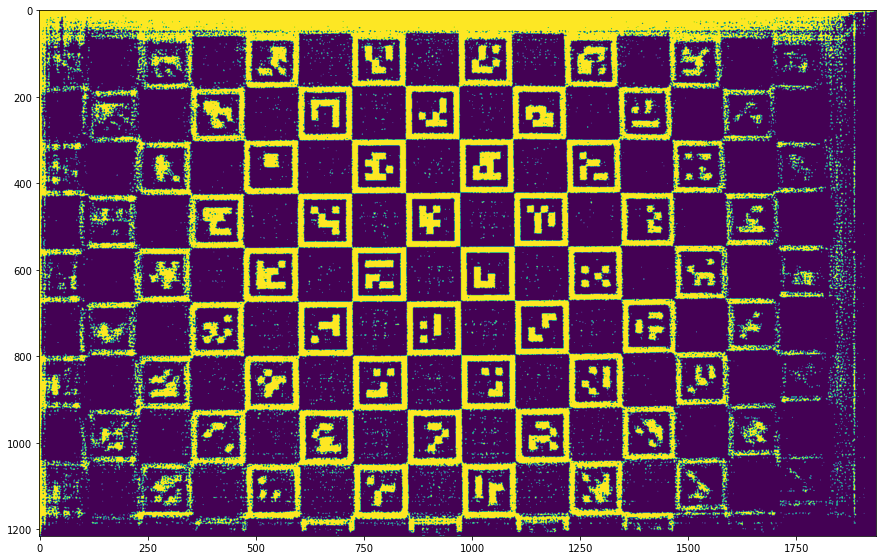

In [4]:
#cv2.goodFeaturesToTrack()

g = skimage.color.rgb2gray(a)
#d.show()

g[g<0.6] = 0
g[g>0.6] = 1
plt.imshow(g)
g = np.uint8(g*255)

#cv2.cvtColor(d,g,)
#corners2 = cv2.goodFeaturesToTrack(img_meta[...,0],40,0.01,10)

ret2, corners2 = cv2.findChessboardCorners(g, (14,9),flags=cv2.CALIB_CB_ADAPTIVE_THRESH +
                                               cv2.CALIB_CB_FAST_CHECK +
                                               cv2.CALIB_CB_NORMALIZE_IMAGE)
#from checkerboard import detect_checkerboard

plt.figure(figsize=(15,15))
plt.imshow(g)
plt.scatter(corners2[:,0,0], corners2[:,0,1])
plt.show()
print(corners2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


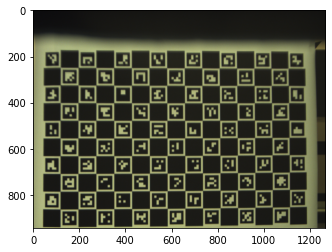

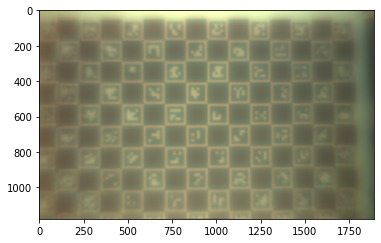

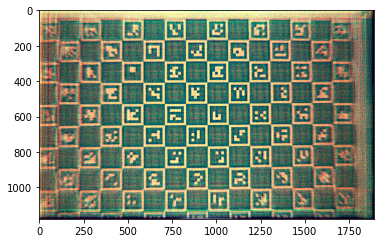

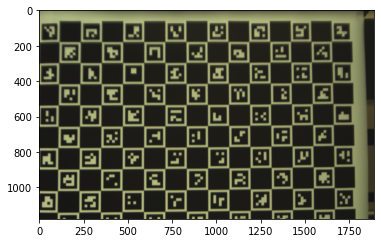

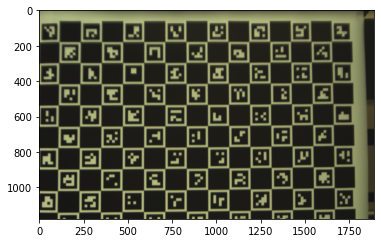

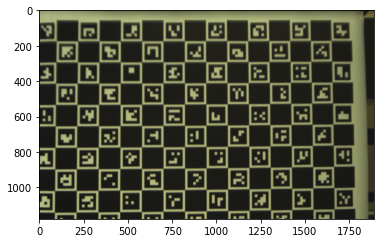

In [5]:
img_gt = plt.imread('./Data/Original/gt.png')
img_meta = plt.imread('./Data/Original/metalens.png')

def get_undist_img(img,mtx,dist):
    h,  w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    # undistort
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    return dst


img_meta = get_undist_img(img_meta,mtx,dist)
img_gt = get_undist_img(img_gt,mtx_gt,dist_gt)
img_gt = np.fliplr(img_gt)

plt.figure()
plt.imshow(img_gt)

plt.figure()
plt.imshow(img_meta)

a = simple_wiener_deconv(new_psf,img_meta,0.000015,300)
plt.figure()
plt.imshow(a)
a = np.uint8(a.clip(0,1)*255)

imageio.imwrite('new_deconv_meta.png', np.uint8(a))

imageio.imwrite('undist_meta_calib.png', np.uint8(img_meta*255))

img_gt = np.uint8(img_gt*255)

imageio.imwrite('new_dist_gt.png', np.uint8(img_gt))

ret1, corners1 = cv2.findChessboardCorners(img_gt, (14,9))



def do_homography(gt_img,undist_meta,H):
    if gt_img.max() < 1.1:
        gt_img = np.uint8(gt_img*255)
    img_warp = cv2.warpPerspective(gt_img, H, (undist_meta.shape[1], undist_meta.shape[0]))
    plt.figure()
    plt.imshow(img_warp)
    return img_warp

img_gt = do_homography(img_gt,img_meta,H)

imageio.imwrite('new_unwarp_gt.png', np.uint8(img_gt))
imageio.imwrite('new_undist_meta.png', np.uint8(img_meta*255))


def crop_offset(x,y,img):
    h,w = img.shape[:2]
    if x > 0:
        indice_w = [x,w]
    else:
        indice_w = [0,w+x]
    if y > 0:
        indice_h = [y,h]
    else:
        indice_h = [0,h+y]
    return img[indice_h[0]:indice_h[1],indice_w[0]:indice_w[1]]


plt.figure()
plt.imshow(img_gt)

img_gt = crop_offset(17,5,img_gt)
img_gt = cv2.resize(img_gt,(img_meta.shape[1],img_meta.shape[0]))

#img_gt = crop_offset(-6,0,img_gt)
#img_gt = cv2.resize(img_gt,(img_meta.shape[1],img_meta.shape[0]))
imageio.imwrite('new_unwarp_cropped_gt.png', np.uint8(img_gt))

plt.figure()
plt.imshow(img_gt)


./Data/Original/GT/1001-19-49-28.653.png
./Data/Original/metalens/1001-19-49-28.601.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.78039217
0.752232015132904
1.0


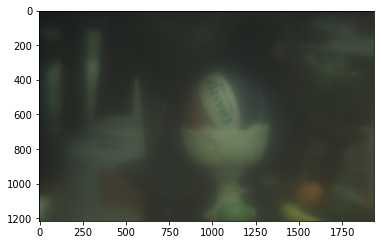

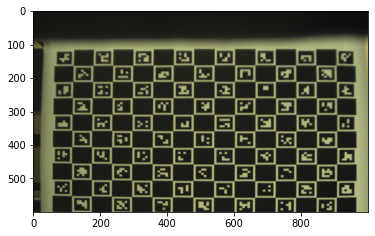

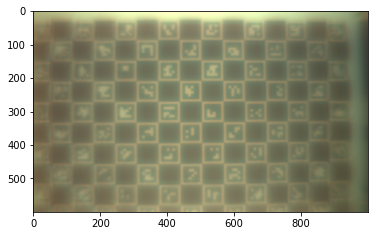

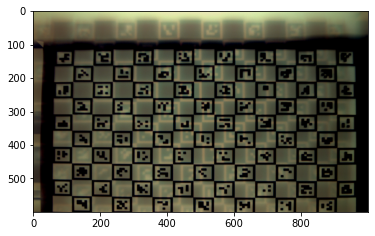

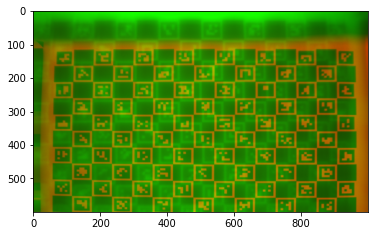

In [6]:
gt_path_list = sorted(glob(input_dataset_path+'GT/*'))
meta_path_list = sorted(glob(input_dataset_path+'metalens/*'))
print(gt_path_list[0])
print(meta_path_list[0])

def cvt_raw2rgb(img_path):
    imageRaw = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE | cv2.IMREAD_ANYDEPTH)
    img_bgr = cv2.cvtColor(imageRaw, cv2.COLOR_BAYER_BG2BGR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb

img_gt = cvt_raw2rgb(meta_path_list[0])
plt.imshow(img_gt)


def images_alignment(img_gt,img_meta):
    # Crop FoV
    w,h,c = img_gt.shape
    img_gt = img_gt[:w-int(w/55),int(h/120):]
    #img_meta = img_meta[80:,:]
    # Match GT size to Meta
    
    #print(w,h)
    w = 600
    h = 1000
    #img_meta = img_meta[:,20:]
    img_gt = cv2.resize(img_gt,(h,w))
    img_meta = cv2.resize(img_meta,(h,w))

    return img_gt, img_meta

i = 1
img_gt = cvt_raw2rgb(gt_path_list[i])
img_meta = cvt_raw2rgb(meta_path_list[i])

img_gt = plt.imread('./Data/Original/gt.png')
img_meta = plt.imread('./Data/Original/metalens.png')
print(img_gt.max())
img_gt,img_meta = images_alignment(img_gt,img_meta)

img_new = np.zeros(img_gt.shape)#.astype(np.uint8)
img_new[...,0] = img_gt[...,0]
print(img_new[...,0].max())
img_new[...,1] = img_meta[...,1]
print(img_new[...,1:].max())

plt.figure()
plt.imshow(img_gt)
plt.figure()
plt.imshow(img_meta)
plt.figure()
plt.imshow(img_meta-img_gt)
plt.figure()
plt.imshow(img_new)

In [7]:
np_psf_path = 'Data/PSF/normalized_psf_601.npy'
psfs = np.load(np_psf_path) 
new_psf = np.zeros((psfs.shape[0],psfs.shape[1],psfs.shape[2])).astype(np.float32)
fake_psf = psfs[...,1]
fake_psf = fake_psf[0,...] + np.flipud(np.transpose(fake_psf)) + np.transpose(fake_psf)
fake_psf = fake_psf + np.fliplr(fake_psf)
fake_psf /= 6
for i in range(3):
    new_psf[...,i] = fake_psf

In [ ]:
def images_alignment(img_gt,img_meta):
    # Crop FoV
    w,h,c = img_gt.shape
    print(w-int(w/60),h)
    img_gt = img_gt[:,int(h/120):h]
    #img_meta = img_meta[80:,:]
    # Match GT size to Meta
    
    #print(w,h)
    w = 600
    h = 1000
    #img_meta = img_meta[:,20:]
    img_gt = cv2.resize(img_gt,(h,w))
    img_meta = cv2.resize(img_meta,(h,w))

    return img_gt, img_meta

def do_homography(gt_img,undist_meta,H):
    if gt_img.max() < 1.1:
        gt_img = np.uint8(gt_img*255)
    img_warp = cv2.warpPerspective(gt_img, H, (undist_meta.shape[1], undist_meta.shape[0]))
    plt.figure()
    plt.imshow(img_warp)
    return img_warp

def generate_dataset(input_dataset_path,output_dataset_path,debug):
    gt_path_list = sorted(glob(input_dataset_path+'GT/*'))
    meta_path_list = sorted(glob(input_dataset_path+'metalens/*'))
    output_res_x = 1000
    output_res_y = 600
    for i in range(0,len(gt_path_list)):
        print(i)
        img_gt = cvt_raw2rgb(gt_path_list[i])
        img_meta = cvt_raw2rgb(meta_path_list[i])
        img_meta = get_undist_img(img_meta,mtx,dist)
        img_gt = get_undist_img(img_gt,mtx_gt,dist_gt)
        img_gt = np.fliplr(img_gt)

        img_gt = do_homography(img_gt,img_meta,H)

        #img_gt = crop_offset(31,5,img_gt)
        

        if debug:
            img_test = np.copy(img_meta)
            img_test = img_test/255
            a = simple_wiener_deconv(new_psf,img_test,0.000015,300)
            plt.imshow(a)
            a = np.uint8(a.clip(0,1)*255)
            a = cv2.resize(a,(output_res_x,output_res_y))
            imageio.imwrite(output_dataset_path+"Deconv/{}.png".format(i), np.uint8(a))
        #print(a.max())

        

        img_gt,img_meta = images_alignment(img_gt,img_meta)
        
        

       


        
        #img_gt,img_meta = images_alignment(img_gt,img_meta)
        imageio.imwrite(output_dataset_path+"GT/{}.png".format(i), np.uint8(img_gt))
        imageio.imwrite(output_dataset_path+"metalens/{}.png".format(i), np.uint8(img_meta))
        

generate_dataset(input_dataset_path,output_dataset_path,False)